[View in Colaboratory](https://colab.research.google.com/github/tao-cao/kdd2018/blob/master/TC_Notebook_3_Movie_Critics.ipynb)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

## Notebook 3

## Using WordEmbeddings and RNNs to classify IMDB reviews: a binary classification problem

This notebook contains code samples that have been adapted from Francois Chollet's Deep Learning With Python.

----
In this notebook we are going to introduce how to use Embeddings and [Recurrent Neural Network(RNN)](https://keras.io/layers/recurrent/) layers in Keras. We are going to introduce the following layers:
* `Embedding`
* `SimpleRNN`
* `LSTM`

We are going look at how to train networks with limited input text data using pre-trained embeddings. Tokenizing and preprocessing input text data will also be illustrated end to end. 

## Problem 
In this notebook, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

# First, a note on using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [3]:
embedding_layer


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

## Dataset
Let's consider IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words, 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` layer on top for classification.

In [0]:
from keras.datasets import imdb
from keras import preprocessing

In [0]:
# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

In [6]:

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

17473536/17464789 [==============================] - 1s 0us/step


In [7]:
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((25000,), (25000,)), ((25000,), (25000,)))

In [0]:
x_train_len_20 = [len(x_train[i]) for i in range(20)]

In [11]:
x_train_len_20

[218,
 189,
 141,
 550,
 147,
 43,
 123,
 562,
 233,
 130,
 450,
 99,
 117,
 238,
 109,
 129,
 163,
 752,
 212,
 177]

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [0]:
x_train_len_20_pad = [len(x_train[i]) for i in range(20)]

In [14]:
x_train_len_20_pad

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]

## Exercise 1: Build and train a Sequential model with the following specs:
* Embedding Layer with maximum number of tokes to be 10000 and embedding dimensionality as 8. Let the input_length be the maximum length of each review i.e 20 as seen previously.
* Flatten the 3D embedding output to 2D.
* Dense Layer which is the classifier.
* Compile the model with a 'rmsprop' optimizer. Can you guess what loss we need to use?
* Let accuracy be one of the metrics we are interested in.
* Run the model on the above training data. 

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# Add an Embedding Layer with maximum number of tokes to be 10000 and embedding dimensionality as 8. 
# Let the input_length be the maximum length of each review i.e 20 as seen previously.
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
# ...
# We add a Dense classifier on top
# ...

# Exercise 1: Solution
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 210us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 3s 169us/step - los

If you used a batch size of 32 and ran the model for 10 epochs you should get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def plot_fun(loss,val_loss):

  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'bo', label='Training loss')

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')

  plt.xlabel('Epochs')

  plt.ylabel('Loss')

  plt.legend()

  plt.show()
  
def plot_acc(loss,acc,val_acc):
  
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')

  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')

  plt.xlabel('Epochs')

  plt.ylabel('Loss')

  plt.legend()


  plt.show()
  

def plt_all(history):

  loss = history.history['loss']

  val_loss = history.history['val_loss']
  
  plot_fun(loss,val_loss)


  acc = history.history['acc']

  val_acc = history.history['val_acc']

  plot_acc(loss,acc,val_acc)

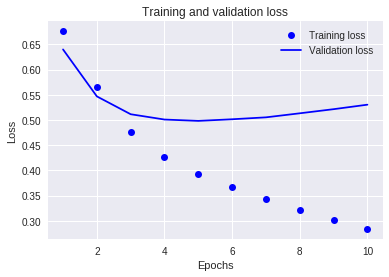

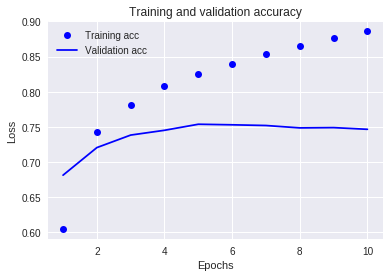

In [20]:
plt_all(history)

## What if we increase the number of words that we consider in each IMDB review? Let maxlen now be 200 instead of 20.

In [21]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 200

# Load the data as lists of integers.
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history_200 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 8)            80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1601      
Total params: 81,601
Trainable params: 81,601
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 170us/step - loss: 0.6630 - acc: 0.6263 - val_loss: 0.5988 - val_acc: 0.7032
Epoch 2/10
20000/20000 [==============================] - 3s 168us/step - loss: 0.5257 - acc: 0.7530 - val_loss: 0.5161 - val_acc: 0.7340
Epoch 3/10
20000/20000 [==============================] - 3s 172us/step - los

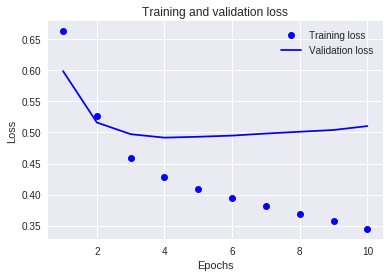

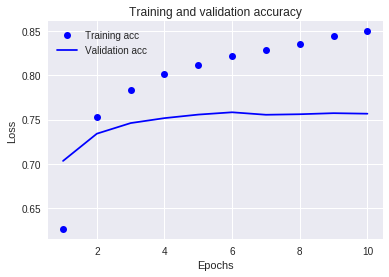

In [22]:
plt_all(history_200)

With a higher number of words considered per review the validation accuracy can increase up to 88%.

# In order to deal with the general hyper parameter like max_features(# of possible tokens), maxlen(# of words considered per input), validation_split=0.2

# a general build model function is created

In [0]:
def build_model(x_train,y_train,max_features = 10000,maxlen = 200,epochs=10,batch_size=32,validation_split=0.2):
  
  from keras.models import Sequential
  from keras.layers import Flatten, Dense
  # Number of words to consider as features
  #max_features = 10000
  # Cut texts after this number of words 
  # (among top max_features most common words)
  #maxlen = 200

  # Load the data as lists of integers.
  #(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

  # This turns our lists of integers
  # into a 2D integer tensor of shape `(samples, maxlen)`
  x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
  #x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
  
  
  # The Embedding layer takes at least two arguments:
  # the number of possible tokens, here 1000 (1 + maximum word index),
  # and the dimensionality of the embeddings, here 64.
  #embedding_layer = Embedding(1000, 64)

  model = Sequential()
  model.add(Embedding(10000, 8, input_length=maxlen)) # the dimensionality of the embeddings, here 8. 
  model.add(Flatten())

  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  model.summary()

  history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
  return history,model

## Using pre-trained word embeddings


When you have very little training data you can leverage pre-computed embeddings that are learnt on a different dataset. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

There are various pre-computed databases of word embeddings that you can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [0]:
import os

imdb_dir = '/Users/anjalisridhar/kdd2018/workshop/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [0]:
glove_dir = '/Users/anjalisridhar/kdd2018/workshop/datasets/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Let's plot its performance over time:

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [0]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

We get an appalling test accuracy of ~55%.

## A first recurrent layer in Keras

In [0]:
from keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence.
Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

## Exercise 2: Lets add a SimpleRNN layer to our model with embedding dimension 32

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
# Add an Embedding layer of 10000 vocab size(or max features) and 32 dimensions
# ...
# Add a SimpleRNN layer of output 32 dimensions
# ...

It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [0]:
# Let us add 3 more SimpleRNN layers. This time we also want to set the 
# `return_sequences` parameter to be True.
# This will return the output for each timestep as opposed to returning the output 
# for only the last timestep.
# Compare model.summary() to see this difference.
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [0]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Let's display the training and validation loss and accuracy:

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## A concrete LSTM example in Keras
Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

## Exercise 3: Use an LSTM layer instead of a SimpleRNN layer

In [0]:
from keras.layers import LSTM

model = Sequential()
# Add an Embedding layer as before with 10000 vocab size(max features) and 32 output dimensions
# ...
# Add a LSTM layer of 32 dimensions
# ...


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You can see that the accuracy is 87%, much higher than what we got with a SimpleRNN layer. 

In [0]:
# Exercise 1: Solution
# model.add(Embedding(10000, 8, input_length=maxlen))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

In [0]:
# Exercise 2: Solution
# model.add(Embedding(10000, 32))
# model.add(SimpleRNN(32))
# model.summary()

In [0]:
# Exercise 3: Solution
# model.add(Embedding(max_features, 32))
# model.add(LSTM(32))
# model.add(Dense(1, activation='sigmoid'))

# a day long practice in CDSW following two example here

In [0]:
# Import Keras and verify that the TensorFlow backend is set as the default.
!pip3 install keras
!pip3 install tensorflow
import keras
keras.__version__

import numpy as np

"""
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

!conda update scikit-learn

!pip3 install scikit-learn
"""

## datasets

"""
Dataset
We will be working with the Reuters dataset, 
a set of short newswires and their topics, 
published by Reuters in 1986. 
It's a very simple, widely used toy dataset for text classification. 
There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

A number of datasets come packaged as part of Keras. A few examples of these Datasets can be found here. Some example datasets are IMDB, MNIST, CIFAR10 etc. The Reuters dataset also comes prepackaged with Keras. Lets take a look at what the data looks like.
"""

from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## The argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

## have 8,982 training examples and 2,246 test examples:

8982+2246

len(train_data)

len(test_data)

train_data.shape,test_data.shape

type(train_data),train_data.shape

## Each example is a list of integers (word indices):

train_data[10]

## Here's how you can decode it back to words, in case you are curious:

word_index = reuters.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

len(reverse_word_index) # 30,979 unique words in the reuters datasets

reverse_word_index.get(0)
reverse_word_index.get(1)
reverse_word_index.get(2)

train_data[0]
train_data[10]



decoded_newswire_train_data_10 = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

decoded_newswire_train_data_10

decoded_newswire_train_data_10_n = ' '.join([reverse_word_index.get(i - 2, '?') for i in train_data[0]])

decoded_newswire_train_data_10_n


# Note that our indices were offset by 3

# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".

decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

decoded_newswire


#Since we limit the number of word index dictionary to the first 10000 words, there is a chance that the newswire will have words that do not have an index associated with it. This is what the ? symbol represents in the above newswire.

#The label associated with an example is an integer between 0 and 45: a topic index.

train_labels[10]

train_labels[0]

train_labels.shape

type(train_labels)

unique, counts = np.unique(train_labels, return_counts=True)

print (np.asarray((unique, counts)).T)

type(counts)

counts.sum()

Preparing the data

We can vectorize the data with the exact same code as in our previous example:

import numpy as np

results = np.zeros((len(train_data), 10000))
type(results), results.shape

type(train_data)

test_train_data = train_data[:2]

type(test_train_data),test_train_data.shape

type(train_data),train_data.shape

results = np.zeros((len(test_train_data), 10000))

results

  for i, data in enumerate(test_train_data):
    print("line %s" %i)
    print(i,data)

    results[i, data] = 1.
results.shape

results[0][:18]

results.shape

def vectorize_sequences(sequences, dimension=10000):

    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):

        results[i, sequence] = 1.

    return results


# Our vectorized training data

x_train = vectorize_sequences(train_data)

# Our vectorized test data

x_test = vectorize_sequences(test_data)

x_train[0][:10]


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index. You can do this using a built-in Keras function:

from keras.utils.np_utils import to_categorical


one_hot_train_labels = to_categorical(train_labels)

type(one_hot_train_labels)
one_hot_train_labels.size
one_hot_train_labels.shape

one_hot_train_labels.shape
train_labels.shape

one_hot_train_labels[:5]

one_hot_test_labels = to_categorical(test_labels)

one_hot_test_labels.shape

Building our network

In this topic classification problem we are trying to classify short snippets of text. 

The difference between a binary classification problem and this one is that the number of output class is 46 

i.e the dimensionality of the output space is much larger. 

(A binary classification problem is one in which there are two possible output clases.)
Build a Sequential model:

from keras import models

from keras import layers

x_train.shape,x_test.shape

# Instantiate a Sequential Model

model = models.Sequential()

# Add 2 Dense layers of 64 units each to the model. Let `relu` be the activation function.

# Note: Specify the input_shape argument for the first layer.

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(64, activation='relu'))

# Add a final Dense layer that classifies the output

# Note: You should use 46 units since out output dimension is going to be the number of output classes). 

# Let `softmax` be the activation function.

model.add(layers.Dense(46, activation='softmax'))

Some things to note about this architecture:

    We are ending the network with a Dense layer of size 46. This means that for each input sample, 
    our network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
    We are using the Relu function for activation.
    The last layer uses a softmax activation. 
    It means that the network will output a probability distribution over the 46 different output classes, 
    i.e. for every input sample, the network will produce a 46-dimensional output vector 
    where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

Compile the model:

Compiling the model is "freezing" the model with certain attributes set such as loss, optimizer, metrics etc.

# Compile the model with a "rmsprop" optimizer, "categorical_crossentropy" loss and "accuracy" \

# metric.

model.compile(optimizer='rmsprop',

              loss='categorical_crossentropy',

              metrics=['accuracy'])

In Keras you can specify the different parameters above as strings such as "rmsprop" or as keras.optimizers.RMSprop. 
You can do the same for loss and metrics. Here are a list of optimizers, loss functions and metrics that are available in Keras.

In our example above the best loss function to use categorical_crossentropy 
since it measures the distance between the probability distribution output by our network and the true distribution of the labels. 

By minimizing the distance between these two distributions, 
we train our network to output something as close as possible to the true labels.

Another point to note is if we had used output labels as integer tensors instead of one-hot encoded vectors, 
then we should usesparse_categorical_crossentropy instead of categorical_crossentropy.
Training our model

Let's set apart 1,000 samples in our training data to use as a validation set:

# Split the training data into train and validation datasets.

x_val = x_train[:1000]

partial_x_train = x_train[1000:]

partial_x_train.shape

​

y_val = one_hot_train_labels[:1000]

partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

# Use the `fit` call with the above training and validation datasets. 

# Use can use a batch size of 512.

history = model.fit(partial_x_train,

                    partial_y_train,

                    epochs=20,

                    batch_size=512,

                    validation_data=(x_val, y_val))

Let's display its loss and accuracy curves:

import matplotlib.pyplot as plt

​

loss = history.history['loss']

val_loss = history.history['val_loss']

​

def plot_fun(loss,val_loss):

  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'bo', label='Training loss')

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')

  plt.xlabel('Epochs')

  plt.ylabel('Loss')

  plt.legend()

  plt.show()

#plt.clf()   # clear figure

plot_fun(loss,val_loss)

​

acc = history.history['acc']

val_acc = history.history['val_acc']

def plot_acc(loss,acc,val_acc):
  
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')

  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')

  plt.xlabel('Epochs')

  plt.ylabel('Loss')

  plt.legend()


  plt.show()

plot_acc(loss,acc,val_acc)

## It seems that the network starts overfitting after 8 epochs.
# Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

# Use the same model from before and train the model as before. 

# However for this run let the number of epochs be 8.

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(46, activation='softmax'))


model.compile(optimizer='rmsprop',

              loss='categorical_crossentropy',

              metrics=['accuracy'])



history_8 = model.fit(partial_x_train,

                    partial_y_train,

                    epochs=8,

                    batch_size=512,

                    validation_data=(x_val, y_val))

Evaluate the model:

# Use `evaluate` the model with the test training input(x_test) and 

# the one-hot encoded labels(one_hot_test_labels).

results = model.evaluate(x_test, one_hot_test_labels)

results

Our approach reaches an accuracy of ~78%. 
With a balanced binary classification problem, 
the accuracy reached by a purely random classifier would be 50%,
but in our case it is closer to 19%, 
so our results seem pretty good, at least when compared to a random baseline:

import copy

​

test_labels_copy = copy.copy(test_labels)

np.random.shuffle(test_labels_copy)

float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

Exercise 1: Now let us try with a larger network with 128 Dense units:

# Use the same model as before but with 128 units set for the first two Dense layers. `compile`, `fit` and `evaluate`

# the model as before. You can also plot the loss and accuracy to see the behavior of the model.



# Define your model here

# ...

model = models.Sequential()

model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',

              loss='categorical_crossentropy',

              metrics=['accuracy'])

print(model.summary())

history_128 = model.fit(partial_x_train,

          partial_y_train,

          epochs=20,

          batch_size=512,

          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

results

​

plt.clf()   # clear figure

def plt_all(history):

  loss = history.history['loss']

  val_loss = history.history['val_loss']
  
  plot_fun(loss,val_loss)


  acc = history.history['acc']

  val_acc = history.history['val_acc']

  plot_acc(loss,acc,val_acc)

plt_all(history_128)
## As you can see, with the larger network we get a slight increase in accuracy 
but the network seems to perform just as good previously.
Exercise 2: Now let us train the model with a single Dense layer network:

# Use the same model as before but with 1 units set for a single Dense layer. `compile`, `fit` and `evaluate`

# the model as before. You can also plot the loss and accuracy to see the behavior of the model.

​



# Define your model here

# 

model = models.Sequential()
model.add(layers.Dense(1, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',

              loss='categorical_crossentropy',

              metrics=['accuracy'])


history_1 = model.fit(partial_x_train,

          partial_y_train,

          epochs=20,

          batch_size=512,

          validation_data=(x_val, y_val))

results_1 = model.evaluate(x_test, one_hot_test_labels)
print(results_1)

plt_all(history_1)



You can see that the accuracy stagnates at around 35% since the network is unable to learn any new information 
from the data.

## Generating predictions on new data

We can verify that the predict method of our model instance returns a probability distribution over all 46 topics.

Let's generate topic predictions for all of the test data:

predictions = model.predict(x_test)

Each entry in predictions is a vector of length 46:

predictions[0].shape

predictions.shape

The coefficients in this vector sum to 1:

np.sum(predictions[0])

The largest entry is the predicted class, i.e. the class with the highest probability:

np.argmax(predictions[0])

predictions[0]

Dealing with overfitting:

Common ways to deal with overfitting is to train the model on more data 
or even to reduce the capacity of the network. 
A bigger network gets its training loss near zero very quickly. 
The more capacity the network has, the quicker it will be able to model the training data 
(resulting in a low training loss), 
but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss). 
Other techniques to deal with overfitting is using weight regularization and dropout. 
Keras provides APIs that make it very simple to use these techniques.
Adding weight regularization:

A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights 
to only take small values, 
which makes the distribution of weight values more "regular". 
This is called "weight regularization", 
and it is done by adding to the loss function of the network a cost associated with having large weights. 
This cost comes in two flavors:

L1 regularization, 
where the cost added is proportional to the absolute value of the weights coefficients 
(i.e. to what is called the "L1 norm" of the weights). 

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients 
(i.e. to what is called the "L2 norm" of the weights). 
L2 regularization is also called weight decay in the context of neural networks. 

Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization. 

In Keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. 

Let's add L2 weight regularization to an example Dense layer:

from keras import regularizers

mock_dense_layer = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,))

Adding dropout:

Dropout, applied to a layer, 
consists of randomly "dropping out" 
(i.e. setting to zero) a number of output features of the layer during training. 
Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] 
for a given input sample during training; after applying dropout,
this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. 
The "dropout rate" is the fraction of the features that are being zeroed-out; 
it is usually set between 0.2 and 0.5. 
At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate,
so as to balance for the fact that more units are active than at training time.

# An example Dropout layer:

#...

mock_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))

mock_model.add(layers.Dropout(0.5)) # 0.5 is the dropout rate

#...

Callbacks

You can use Keras built-in callbacks to checkpoint your model, save TensorBoard summaries, adjust learning rate during training etc. Callbacks are a way to perform an action, view internal state or model statistics at the beginning/end of the training loop, an epoch or a step in the fit loop. Let's instantiate the ModelCheckpoint and TensorBoard callback:
Exercise 3: Create a ModelCheckpoint and TensorBoard callback.

from keras import callbacks

# Create a ModelCheckpoint callback by specifying a filepath such a s'/tmp/checkpoints'. 
# You can look at some of the

# other parameters that you can set in the link above.

# ...



# 

# Create a ModelCheckpoint callback

# model_checkpoint_cb = 

model_checkpoint_cb = callbacks.ModelCheckpoint('/tmp/checkpoints',
                                                monitor='val_loss',
                                                period=1)

# Create a TensorBoard callback that writes model summaries to a given directory such as '/tmp/logs'.

# tensorboard_cb = 

tensorboard_cb = callbacks.TensorBoard(log_dir='/tmp/logs')

# Let us use our model from above:

from keras import models

from keras import layers


model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(46, activation='softmax'))


model.compile(optimizer='rmsprop',

              loss='categorical_crossentropy',

              metrics=['accuracy'])


# Pass the callbacks instantiated above to the `callbacks` parameter in the `fit` call.

history_64 = model.fit(partial_x_train,

          partial_y_train,

          epochs=20,

          batch_size=512,

          validation_data=(x_val, y_val),

          callbacks=[model_checkpoint_cb, tensorboard_cb])

## You should be able to view TensorBoard summaries by using the following command: 

## tensorboard --logdir=/full_path_to_your_logs. Make sure to have installed the TensorBoard pip package.
!ls /tmp/logs

!ls /tmp/checkpoints
!tensorboard --logdir=/tmp/logs
# Exercise 1: Solution

plt_all(history_64)

# model = models.Sequential()

# model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))

# model.add(layers.Dense(128, activation='relu'))

# model.add(layers.Dense(46, activation='softmax'))

# Exercise 2: Solution

# model = models.Sequential()

# model.add(layers.Dense(1, activation='relu', input_shape=(10000,)))

# model.add(layers.Dense(46, activation='softmax'))

# Exercise 3: Solution

# model_checkpoint_cb = callbacks.ModelCheckpoint('/tmp/checkpoints',

#                                                monitor='val_loss',

#                                                period=1)

​

# tensorboard_cb = callbacks.TensorBoard(log_dir='/tmp/logs')

"""

Dataset
Let's consider IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare the data. We will restrict the movie reviews to the top 10,000 most common words, and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single Dense layer on top for classification.

"""

from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
imdb_max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
#imdb_maxlen = 20

# Load the data as lists of integers.
(imdb_x_train, imdb_y_train), (imdb_x_test, imdb_y_test) = imdb.load_data(num_words=imdb_max_features)

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding

model = Sequential()
# Add an Embedding Layer with maximum number of tokes to be 10000 and embedding dimensionality as 8. 
# Let the input_length be the maximum length of each review i.e 20 as seen previously.
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
# ...
# We add a Dense classifier on top
# ...

# Exercise 1: Solution
maxlen = 20

"""no padding 
will have this error
ValueError: Error when checking input: expected embedding_2_input to have shape (20,) but got array with shape (1,)

"""

model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history_20 = model.fit(imdb_x_train, imdb_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


def build_model(x_train,y_train,max_features = 10000,maxlen = 200,epochs=10,batch_size=32,validation_split=0.2):
  
  from keras.models import Sequential
  from keras.layers import Flatten, Dense
  # Number of words to consider as features
  #max_features = 10000
  # Cut texts after this number of words 
  # (among top max_features most common words)
  #maxlen = 200

  # Load the data as lists of integers.
  #(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

  # This turns our lists of integers
  # into a 2D integer tensor of shape `(samples, maxlen)`
  x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
  #x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
  
  
  # The Embedding layer takes at least two arguments:
  # the number of possible tokens, here 1000 (1 + maximum word index),
  # and the dimensionality of the embeddings, here 64.
  #embedding_layer = Embedding(1000, 64)

  model = Sequential()
  model.add(Embedding(10000, 8, input_length=maxlen)) # the dimensionality of the embeddings, here 8. 
  model.add(Flatten())

  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  model.summary()

  history_200 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
  return history_200,model

hist_20,model_20 = build_model(imdb_x_train,imdb_y_train,maxlen = 20)

plt_all(hist_20)

hist_200,model_200 = build_model(imdb_x_train,imdb_y_train,maxlen = 200)
plt_all(hist_200)

## Putting it all together: from raw text to word embeddings

import os
# /resources/data/imdb_raw/aclImdb
imdb_dir = 'resources/data/imdb_raw/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
train_dir
labels = []
texts = []


for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    
    print(dir_name)

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
len(texts),len(labels)

print('Shape of data :', len(texts))
print('Shape of label tensor:', len(labels))

labels[1],texts[1]

for i in range(10):
  print("line %s review --- it is a %d ------" %(i,labels[i]))
  print(texts[i])

import numpy as np
key,values = np.unique(labels,return_counts=True)

key,values

## Tokenize the data
Let's vectorize the texts we collected, and prepare a training and validation split. 
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems 
where little training data is available 
(otherwise, task-specific embeddings are likely to outperform them), 
we will add the following twist: we restrict the training data to its first 200 samples.
  
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words) #
"""
num_words: the maximum number of words to keep, 
based on word frequency. Only the most common num_words words will be kept.

The Tokenizer stores everything in the word_index during fit_on_texts. 
Then, when calling the texts_to_sequences method, only the top num_words are considered.
"""
test_texts3 = ['a a a', 'b b', 'c',"d d d d"]
test_tokenizer = Tokenizer(num_words=2)
test_tokenizer.fit_on_texts(test_texts)

test_tokenizer.word_index

test_sequence = test_tokenizer.texts_to_sequences(test_texts)
test_sequence

test_tokenizer3 = Tokenizer(num_words=3)
test_tokenizer3.fit_on_texts(test_texts3)

test_tokenizer3.word_index

test_sequence3 = test_tokenizer3.texts_to_sequences(test_texts3)
test_sequence3

tokenizer.fit_on_texts(texts) # texts are the whole datasets(train+test)
sequences = tokenizer.texts_to_sequences(texts) #Converts a text to a sequence of words (or tokens).
type(sequences)

len(sequences)

for i in range(5):
  print("line %s review --- it is a %d ------" %(i,labels[i]))
  print(len(texts[i]),texts[i])
  print(len(sequences[i]),sequences[i])

for i in range(5):
  print("line %s review --- it is a %d ------" %(i,labels[i]))
  print(len(texts[i].split()),texts[i])
  print("tokenized sequence --------")
  print(len(sequences[i]),sequences[i])

word_index = tokenizer.word_index #
print('Found %s unique tokens.' % len(word_index))

type(word_index)
word_index["this"]

word_index["i"]
word_index["the"]


"""  pad_sequences
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
#x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

"""
type(sequences)

len_sequences_10 = [len(sequences[i]) for i in range(10)]
len_sequences_10

maxlen

data = pad_sequences(sequences, maxlen=maxlen)

len_data_10 = [len(data[i]) for i in range(10)]
len_data_10

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

## Pre-process the embeddings
Let's parse the un-zipped file (it's a txt file) to build an index mapping words (as strings) to their vector representation (as number vectors)

glove_dir = 'resources/data/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embeddings_index["love"]

len(embeddings_index["love"])

max_words #10000

embedding_dim = 100

# initiate the embedding_matrix with 0
embedding_matrix = np.zeros((max_words, embedding_dim))
embedding_matrix.shape #(10000, 100)

#word_index.items() very long list from tokenizer

"""
some example:

('sixteenth', 25417), 
('brethren', 25418), 
('pasty', 25419), 
('slinky', 25420), 
("office'", 25421), 
('pd', 25422), 
"""
max_words

# get the embedding_matrix from pre-tainined embeddings
for word, i in word_index.items(): #word_index is from the tokenizer
    embedding_vector = embeddings_index.get(word) # get the embedding values( in this case is 100 dimension)
    if i < max_words: # only use the most frequency word selected by max_words
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros. from paddings
            embedding_matrix[i] = embedding_vector
maxlen            
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_pre_train = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('tc_pre_trained_glove_model.h5')

def plot_one(history):
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
# plot
plot_one()

## train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. 

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

plot_one(history_pre_train)

plot_one(history)

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


model.evaluate(x_test, y_test)

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

## pre trainined embedding is better
max_features = 10000

from keras.layers import LSTM

model = Sequential()
# Add an Embedding layer as before with 10000 vocab size(max features) 
#and 32 output dimensions
# ...
# Add a LSTM layer of 32 dimensions
# ...
# Exercise 3: Solution
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_lstm = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
plot_one(history_lstm)

## using the imdb data to to train LSTM

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

model = Sequential()
# Add an Embedding layer as before with 10000 vocab size(max features) 
#and 32 output dimensions
# ...
# Add a LSTM layer of 32 dimensions
# ...
# Exercise 3: Solution
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_lstm = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
plot_one(history_lstm)
